<a href="https://colab.research.google.com/github/Akons97/DeepNoiseSuppression/blob/master/Noise_suppression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import soundfile as sf
from scipy import signal
import IPython.display as ipd
# !pip3 install https://github.com/schmiph2/pysepm/archive/master.zip
import pysepm

import tensorflow as tf
from tensorflow.keras  import backend as K
from tensorflow.keras.models import load_model, save_model

     | 2.1MB 3.2MB/s
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     | 276kB 29.9MB/s
     \ 61kB 42.7MB/s
     \ 65.4MB 48kB/s
     |████████████████████████████████| 163kB 28.4MB/s 
  Created wheel for pysepm: filename=pysepm-0.1-cp37-none-any.whl size=24291 sha256=a30c1f3d1b7c9116a161be62730cfa9af631ffda49fb92d8f88ccd8ea6056e1e
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1ao5u0x/wheels/17/75/23/17712e0da834688ac430e0cf826dd1f7450d0b4873e0269f7c
Successfully built pysepm
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7781 sha256=8adff3a6a43eaf940a7a2a113fa0f5426192295df56a2a080d88b0af1cdd19d4
  Stored in directory: /root/.cache/pip/wheels/6b/6c/b2/d49af4b7ee4ce275cf2511484b043e09b9cb7ae90c1accb17a
  Created wheel for pesq: filename=pesq-0.0.2-cp37-cp37m-linux_x86_64.whl size=210729 sha256=0becdbb2e89a34ae5a2e7f5076e0608ffd207aa294f89530135fb20e78a7c887
  Stored in di

# Utility functions

In [2]:
def L_speech(y_true, y_pred):
  return K.mean(K.square(y_true - y_true * y_pred), axis=-1)

def L_noise(y_true, y_pred):
  return K.mean(K.square(y_pred * (y_true - y_pred)), axis=-1)

def fixed_weighted_loss(L_speech, L_noise, alpha=0.35):
  return aplha * L_speech + (1 - alpha) * L_noise

def my_crossentropy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.binary_crossentropy(y_pred, y_true), axis=-1)

def mymask(y_true):
    return K.minimum(y_true+1., 1.)

def msse(y_true, y_pred):
    return K.mean(mymask(y_true) * K.square(K.sqrt(y_pred) - K.sqrt(y_true)), axis=-1)

def mycost(y_true, y_pred):
     return K.mean(mymask(y_true) * (10*K.square(K.square(K.sqrt(y_pred) - K.sqrt(y_true))) + K.square(K.sqrt(y_pred) - K.sqrt(y_true)) + 0.01*K.binary_crossentropy(y_pred, y_true)), axis=-1)

def my_accuracy(y_true, y_pred):
    return K.mean(2*K.abs(y_true-0.5) * K.equal(y_true, K.round(y_pred)), axis=-1)


# list of mfcc deltas, adds 0 to the beginning
def get_diff_list(data):
    L = []
    for d in data:
        L.append(np.concatenate([[d[0]], np.diff(d, axis=-2)], axis=-2))
    return np.array(L)


def normalize(data, n, quantize=True):
    limit = pow(2, n)
    data = np.clip(data, -limit, limit)/limit
    if quantize:
        data = np.round(data * 128)/ 128.0
    return data


def iir_design(band_frequency, samplerate, order=1): # the band frequency is the middle freq
    b = []
    a = []
    fre = band_frequency / (samplerate/2)
    for i in range(1, len(band_frequency)-1):
        b_, a_ = signal.iirfilter(order, [fre[i] - (fre[i]-fre[i-1])/2, fre[i]+ (fre[i+1]-fre[i])/2], btype='bandpass', output='ba')
        b.append(b_)
        a.append(a_)
    return b, a


def bandpass_filter_iir(sig, b_in, a_in, step, gains):
    x = sig
    y = np.zeros(len(x))
    state = np.zeros(len(b_in)-1)
    g=0
    for n in range(0, len(gains)):
        g = max(0.6*g, gains[n])    # r=0.6 pre RNNoise paper https://arxiv.org/pdf/1709.08243.pdf
        b = b_in*g
        a = a_in
        filtered, state = signal.lfilter(b, a, x[n*step: min((n+1)*step, len(x))], zi=state)
        y[n*step: min((n+1)*step, len(x))] = filtered
    return y


def filter_voice(sig, rate, gains, nband=22, lowfreq=20, highfreq=8000):
    # see gen_dataset.py's example for detial
    band_freq = lr.mel_frequencies(n_mels=nband, fmin=lowfreq, fmax=highfreq)
    # band_freq = lr.mel_to_hz(mel_scale)
    band_frequency = band_freq[1:-1] # the middle point of each band
    print('band frequency', band_frequency)
    b, a = iir_design(band_freq, rate, order=1)
    step = int(0.020 * rate / 2)
    # step = int(0.020 * rate * 0.75)
    filtered_signal = np.zeros(len(sig))
    for i in range(len(b)):
        filtered_signal += bandpass_filter_iir(sig, b[i].copy(), a[i].copy(), step, gains[:, i])
        print("filtering with frequency: ", band_frequency[i])
    filtered_signal = filtered_signal * 0.6
    return filtered_signal


def voice_denoise(sig, rate, model, timestamp_size=512, numcep=22, plot=False):
    # sig = sig / 32768
    num_diffs = 10
    window_length = int(np.round(0.020*rate))
    hop_length = int(np.round(0.010*rate))
    # hop_length = int(np.round(0.020 * rate * 0.75))
    # get the mfcc of noisy voice
    mfcc_feat = lr.feature.mfcc(sig, rate, n_mfcc=numcep, n_fft=512, win_length = window_length, hop_length = hop_length, dct_type=2, lifter=0, fmin=20, fmax=8000)
    mfcc_feat = mfcc_feat.astype('float32')
    # mfcc_feat = mfcc_feat[:,:3888]
    mfcc_feat = mfcc_feat.T
    print("mfcc_feat.shape: ", mfcc_feat.shape) # (6223, 22)
    # differential of mfcc, add 0 to the beginning
    diff = np.diff(mfcc_feat, axis=0)
    diff = np.concatenate([[mfcc_feat[0]], diff], axis=0)  # first derivative
    diff1 = np.diff(diff, axis=0)
    diff1 = np.concatenate([[diff[0]], diff1], axis=0) # second derivative
    diff = diff[:, :num_diffs]
    diff1 = diff1[:, :num_diffs]
    # concat both differential and original mfcc
    print("diff.shape: ", diff.shape)
    print("diff1.shape: ", diff1.shape)
    feat = np.concatenate([mfcc_feat, diff, diff1], axis=-1)
    print("1feat.shape: ", feat.shape)
    # requantise the MFCC (same as training data)
    feat = normalize(feat, 3, quantize=False)
    print("2feat.shape: ", feat.shape)
    feat = np.reshape(feat, (feat.shape[0], 1, feat.shape[1])) # 
    print("3feat.shape: ", feat.shape)
    feat = feat[: feat.shape[0] // timestamp_size * timestamp_size]
    print("4feat.shape: ", feat.shape)
    prediction = model.predict(feat, batch_size=timestamp_size)
    if(type(prediction) is list):
        predicted_gains = prediction[0]
        predicted_vad = prediction[1]
    else:
        predicted_gains = prediction
        predicted_vad = None

    # now process the signal.
    print('predicted_gains: ', predicted_gains.shape)
    # filtered_sig = filter_voice(sig, rate=rate, gains=predicted_gains, nband=mfcc_feat.shape[-1])
    filtered_sig = filter_voice(sig, rate=rate, gains=predicted_gains, nband=mfcc_feat.shape[1]+2)
    if(plot):
        plt.figure(figsize=(20, 7))
        for i in range(10):
            plt.plot(predicted_gains[:, i], label='band'+str(i))
        if(predicted_vad is not None):
            plt.plot(predicted_vad, 'r', label='VAD')
        plt.ylabel("Gains")
        plt.xlabel("MFCC Sample")
        plt.legend()
        plt.show()
    return filtered_sig

# Load Dataset and prepare data

In [3]:
# load training dataset
try:
    dataset = np.load('drive/MyDrive/Noise suppression/dataset.npz', allow_pickle=True)
except:
    raise Exception("Given dataset not found.")

# extract mfcc, vad and gains
clnsp_mfcc = dataset['clnsp_mfcc']    # clean speech mfccs
noisy_mfcc = dataset['noisy_mfcc']    # noisy speech mfccs
vad = dataset['vad']                  # voice activation detection
gains = dataset['gains']              # gains
# get mfcc differences(deltas) from dataset.
clnsp_mfcc_diff = get_diff_list(clnsp_mfcc)
noisy_mfcc_diff = get_diff_list(noisy_mfcc)
clnsp_mfcc_diff1 = get_diff_list(clnsp_mfcc_diff)
noisy_mfcc_diff1 = get_diff_list(noisy_mfcc_diff)

# combine all pieces to one large array
clnsp_mfcc = np.concatenate(clnsp_mfcc, axis=0)
noisy_mfcc = np.concatenate(noisy_mfcc, axis=0)
clnsp_mfcc_diff = np.concatenate(clnsp_mfcc_diff, axis=0)
noisy_mfcc_diff = np.concatenate(noisy_mfcc_diff, axis=0)
clnsp_mfcc_diff1 = np.concatenate(clnsp_mfcc_diff1, axis=0)
noisy_mfcc_diff1 = np.concatenate(noisy_mfcc_diff1, axis=0)
vad = np.concatenate(vad, axis=0)
gains = np.concatenate(gains, axis=0)

# these max and min are rear
print('mfcc max:', noisy_mfcc.max(), 'mfcc min:', noisy_mfcc.min())
print('mfcc diff max:', noisy_mfcc_diff.max(), 'mfcc diff min:', noisy_mfcc_diff.min())

# preprocess data
timestamp_size = 2048 # this must be > than 1024, since we are using 1 sample as a batch, which still too small for BP
num_sequence = len(vad) // timestamp_size
print('timestamp', timestamp_size, 'num of data', num_sequence)

# prepare data
diff = np.copy(noisy_mfcc_diff[:num_sequence * timestamp_size, :10])
diff1 = np.copy(noisy_mfcc_diff1[:num_sequence * timestamp_size, :10])
feat = np.copy(noisy_mfcc[:num_sequence * timestamp_size, :])

# concat mfcc, 1st and 2nd derivative together as the training data.
x_train = np.concatenate([feat, diff, diff1], axis=-1)
# convert MFCC range to -1 to 1.0 In quantization, we will saturate them to leave more resolution in smaller numbers
# we saturate the peak to leave some more resolution in other band.
x_train = normalize(x_train, 3, quantize=False)

# reshape
x_train = np.copy(x_train[:num_sequence * timestamp_size, :])
x_train = np.reshape(x_train, (num_sequence* timestamp_size, 1, x_train.shape[-1]))
y_train = np.copy(gains[:num_sequence * timestamp_size,:])
y_train = np.reshape(y_train, (num_sequence* timestamp_size, gains.shape[-1]))
vad_train = np.copy(vad[:num_sequence * timestamp_size]).astype(np.float32)
vad_train = np.reshape(vad_train, (num_sequence * timestamp_size, 1))
print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)
print("vad_train.shape: ", vad_train.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


mfcc max: 24.701464 mfcc min: -19.636553
mfcc diff max: 17.281946 mfcc diff min: -18.920414
timestamp 2048 num of data 2645
x_train.shape:  (5416960, 1, 42)
y_train.shape:  (5416960, 22)
vad_train.shape:  (5416960, 1)


# Define Model

In [4]:
def train(x_train, y_train, vad_train, batch_size=64, epochs=10, model_name="model.h5"):
    """
    RNNoise-like structure with some adaption to fit NNoM's implementation.
    """
    input_feature_size = x_train.shape[-1] # 42
    output_feature_size = y_train.shape[-1] # 22
    timestamp_size = batch_size # 2048
    input = tf.keras.Input(shape=(1, input_feature_size), batch_size=timestamp_size) # (1, 42, 2048)
    
    """
        This is an RNNoise-like structure
    """
    # voice activity detection
    # x1_1 = tf.keras.layers.GRU(24, return_sequences=True, stateful=True, recurrent_dropout=0.2)(input)
    x1_1 = tf.keras.layers.Dense(24, activation="tanh")(input)
    # x1_1 = tf.keras.layers.Dropout(0.3)(x1_1)
    x1_2 = tf.keras.layers.GRU(24, activation="relu", reset_after=False, return_sequences=True, recurrent_dropout=0.2)(x1_1)
    x1_2 = tf.keras.layers.Dropout(0.3)(x1_2)
    x = tf.keras.layers.Flatten()(x1_2)
    # x = tf.keras.layers.Dropout(0.3)(x)
    vad_output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    # vad_output = tf.keras.layers.Activation("sigmoid")(x)

    # we dont concate input with layer output, because the range different will cause quite many quantisation lost.
    # x_in = tf.keras.layers.GRU(64, return_sequences=True, stateful=True, recurrent_dropout=0.3)(input)

    # Noise spectral estimation
    x2 = tf.keras.layers.concatenate([input, x1_1, x1_2], axis=-1)
    x2 = tf.keras.layers.GRU(48, activation="relu", reset_after=False, return_sequences=True, recurrent_dropout=0.2)(x2)
    x2 = tf.keras.layers.Dropout(0.3)(x2)

    #Spectral subtraction
    x3 = tf.keras.layers.concatenate([input, x2, x1_2], axis=-1)
    x3 = tf.keras.layers.GRU(96, activation="relu", reset_after=False, return_sequences=True, recurrent_dropout=0.2)(x3)
    x3 = tf.keras.layers.Dropout(0.3)(x3)
    x = tf.keras.layers.Flatten()(x3)
    x = tf.keras.layers.Dense(output_feature_size, activation="sigmoid")(x) #output_feature_size
    # x = tf.keras.layers.Activation("sigmoid")(x)

    model = tf.keras.Model(inputs=input, outputs=[x, vad_output])
    alpha = 0.35
    # model.compile("adam", loss=[L_speech, L_noise], loss_weights=[alpha, 1-alpha])
    # model.compile("adam", loss=[mycost, my_crossentropy], loss_weights=[10, 2], metrics=[msse])
    model.compile("adam", loss=[mycost, my_crossentropy], loss_weights=[10, 0.5], metrics=[msse])
    # model.compile("adam", loss=["MSE", "binary_crossentropy"], loss_weights=[10, 2])
    model.summary()

    history = model.fit(x_train, [y_train, vad_train], batch_size=timestamp_size, epochs=epochs, verbose=2, shuffle=False)

    # free the session to avoid nesting naming while we load the best model after.
    tf.keras.models.save_model(model, model_name)
    del model
    K.clear_session()
    return history

# Train Model

In [ ]:
# training
history = train(x_train, y_train, vad_train, batch_size=timestamp_size, epochs=4, model_name="model.h5")

# get the best model
# model = tf.keras.models.load_model("model.h5", custom_objects={'L_speech': L_speech, 'L_noise': L_noise})
model = tf.keras.models.load_model("model.h5", custom_objects={'mycost': mycost, 'msse': msse, 'my_crossentropy': my_crossentropy, 'my_accuracy': my_accuracy})
# model = tf.keras.models.load_model("model.h5")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(2048, 1, 42)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (2048, 1, 24)        1032        input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       (2048, 1, 24)        3528        dense[0][0]                      
__________________________________________________________________________________________________
dropout (Dropout)               (2048, 1, 24)        0           gru[0][0]                        
______________________________________________________________________________________________

# Denoise a file

min:  -0.7368469
max:  0.65802
rate:  16000
mfcc_feat.shape:  (4065, 22)
diff.shape:  (4065, 10)
diff1.shape:  (4065, 10)
1feat.shape:  (4065, 42)
2feat.shape:  (4065, 42)
3feat.shape:  (4065, 1, 42)
4feat.shape:  (2048, 1, 42)
predicted_gains:  (2048, 22)
band frequency [ 150.27721876  280.55443752  410.83165628  541.10887504  671.3860938
  801.66331256  931.94053131 1066.26694684 1219.59101481 1394.96234766
 1595.55123625 1824.98384401 2087.4077593  2387.56697376 2730.88764223
 3123.57617459 3572.73143267 4086.47306053 4674.08826808 5346.19972142
 6114.95757505 6994.25911733]
filtering with frequency:  150.2772187592028
filtering with frequency:  280.5544375184056
filtering with frequency:  410.83165627760843
filtering with frequency:  541.1088750368112
filtering with frequency:  671.3860937960142
filtering with frequency:  801.6633125552169
filtering with frequency:  931.9405313144198
filtering with frequency:  1066.2669468420474
filtering with frequency:  1219.591014807845
filterin

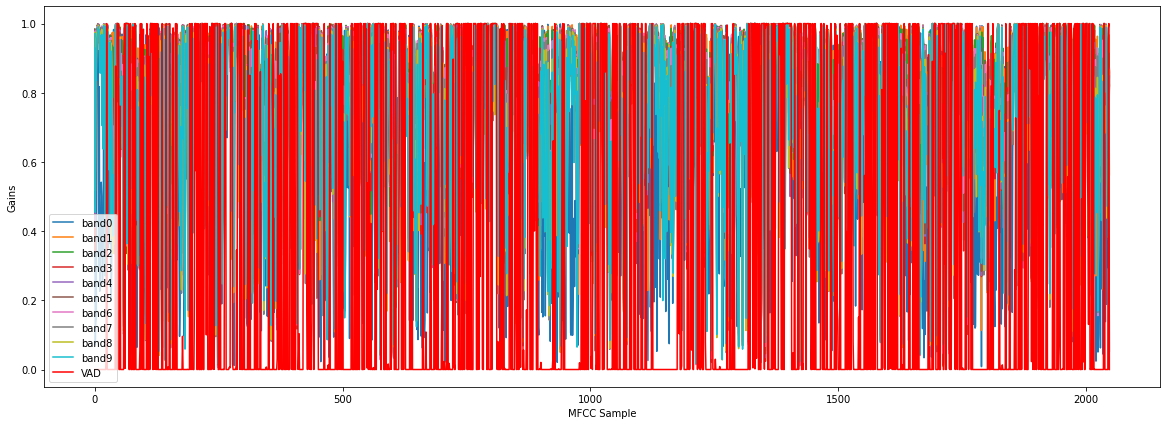

min:  -14918
max:  9595


In [ ]:
# Make sure the MFCC parameters inside the voice_denoise() are the same as our gen_dataset.

# Load noisy file
(sig, rate) = lr.load("drive/MyDrive/Noise suppression/_noisy_sample_typing.wav", sr=16000)
# sig = np.asarray(sig * 32767, dtype=np.int16)
print('min: ', np.min(sig))
print('max: ', np.max(sig))
print('rate: ', rate)
# Denoising
filtered_sig = voice_denoise(sig, rate, model, timestamp_size, numcep=y_train.shape[-1], plot=True) # use plot=True argument to see the gains/vad
filtered_sig = np.asarray(filtered_sig * 32767, dtype=np.int16)
# Write denoised file
sf.write("_nn_filtered_sample_new.wav", filtered_sig, rate)

print('min: ', np.min(filtered_sig))
print('max: ', np.max(filtered_sig))

# Speech Evaluation - Clean vs Ground Trugh Gains Filtered

In [ ]:
rate = 8000
(x, _) = lr.load("drive/MyDrive/Noise suppression/_clean_sample_neighbor.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

(y, _) = lr.load("drive/MyDrive/Noise suppression/_filtered_sample_neighbor.wav", rate, duration=30)
y = np.asarray(y * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, y, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, y, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (3.4234168256451425, 3.446876049041748)
stoi:  0.763704859257961


# Speech Evaluation - Clean vs NN Denoised

In [ ]:
(x, _) = lr.load("drive/MyDrive/Noise suppression/_clean_sample_neighbor.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

(fs, _) = lr.load("drive/MyDrive/Noise suppression/_pm_neighbor_filtered_sample.wav", sr=rate, duration=30)
fs = np.asarray(fs * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, fs, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, fs, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (2.9115385228035175, 2.6920392513275146)
stoi:  0.6840145336668794


# Speech Evaluation - Clean vs RNNdenoised

In [ ]:
(x, _) = lr.load("drive/MyDrive/Noise suppression/_clean_sample.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

(fs, _) = lr.load("drive/MyDrive/Noise suppression/_rnn-denoise_filtered_sample.wav", sr=rate, duration=30)
fs = np.asarray(fs * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, fs, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, fs, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (2.865565172270222, 2.625328540802002)
stoi:  0.7352920358003048


# Speech Evaluation - Clean vs Noisy Speech

In [ ]:
(x, _) = lr.load("drive/MyDrive/Noise suppression/_clean_sample_neighbor.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

(n, _) = lr.load("drive/MyDrive/Noise suppression/_noisy_sample_neighbor.wav", rate, duration=30)
n = np.asarray(n * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, n, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, n, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (2.9640464449158923, 2.7690882682800293)
stoi:  0.7138616117895749


# Listening

## Ground truth denoised

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

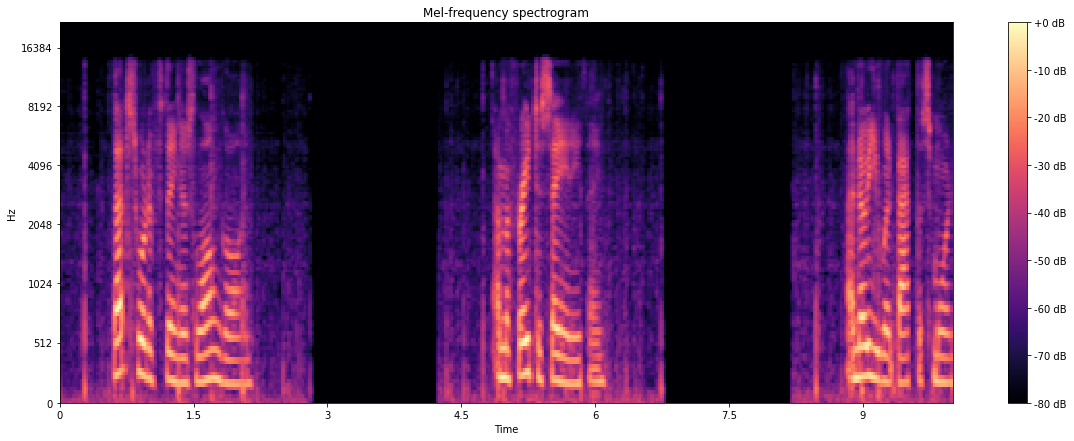

In [ ]:
import librosa.display

ipd.Audio("drive/MyDrive/Noise suppression/_filtered_sample_typing.wav")
a, sr = lr.load("drive/MyDrive/Noise suppression/_filtered_sample_typing.wav", duration=10)
S = lr.feature.melspectrogram(y=a, sr=sr)
fig, ax = plt.subplots(figsize=(20, 7))
S_dB = lr.power_to_db(S, ref=np.max)
img = lr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## Noisy sample

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

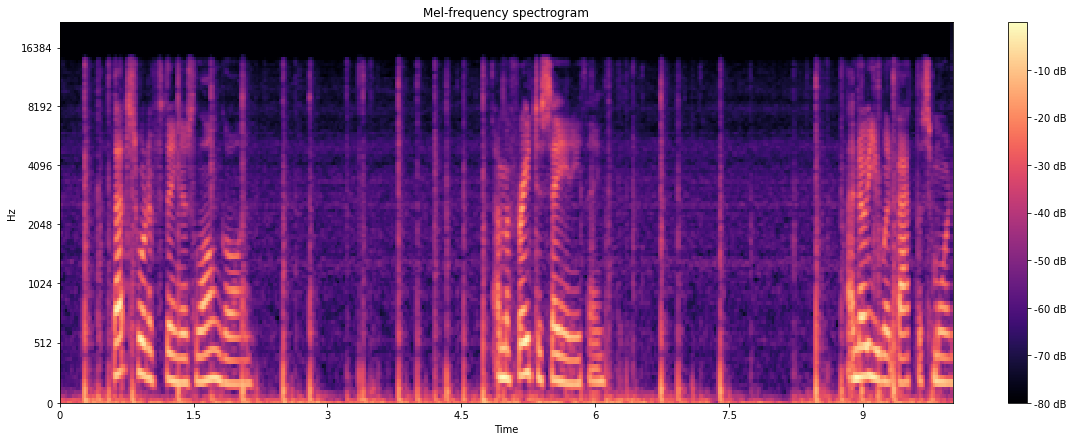

In [ ]:
import librosa.display

ipd.Audio("drive/MyDrive/Noise suppression/_noisy_sample_typing.wav")
a, sr = lr.load("drive/MyDrive/Noise suppression/_noisy_sample_typing.wav", duration=10)
S = lr.feature.melspectrogram(y=a, sr=sr)
fig, ax = plt.subplots(figsize=(20, 7))
S_dB = lr.power_to_db(S, ref=np.max)
img = lr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## NN denoised sample

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

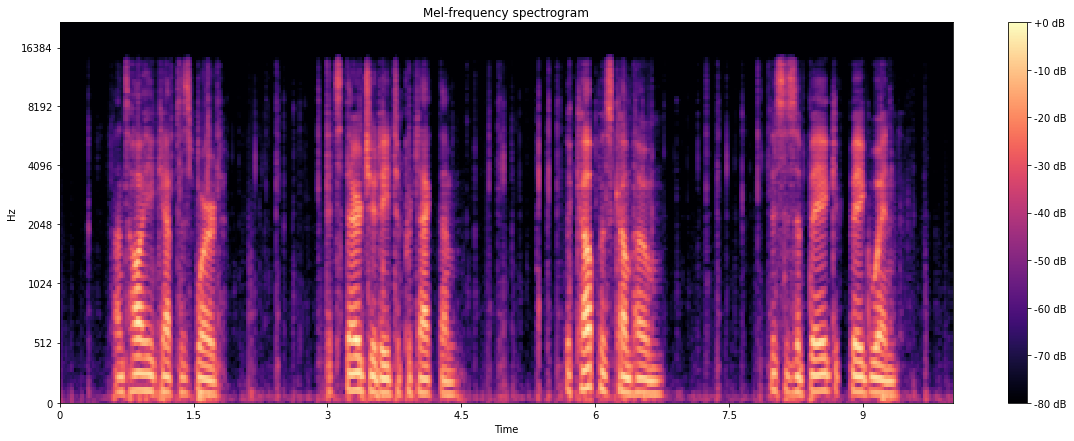

In [ ]:
import librosa.display

ipd.Audio("drive/MyDrive/Noise suppression/_HYB_rnn-denoise_filtered_sample.wav")
a, sr = lr.load("drive/MyDrive/Noise suppression/_HYB_rnn-denoise_filtered_sample.wav", duration=10)
S = lr.feature.melspectrogram(y=a, sr=sr)
fig, ax = plt.subplots(figsize=(20, 7))
S_dB = lr.power_to_db(S, ref=np.max)
img = lr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

## RNNdenoised sample

In [ ]:
ipd.Audio("drive/MyDrive/Noise suppression/_rnn-denoise_filtered_sample.wav")

## Clean sample

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

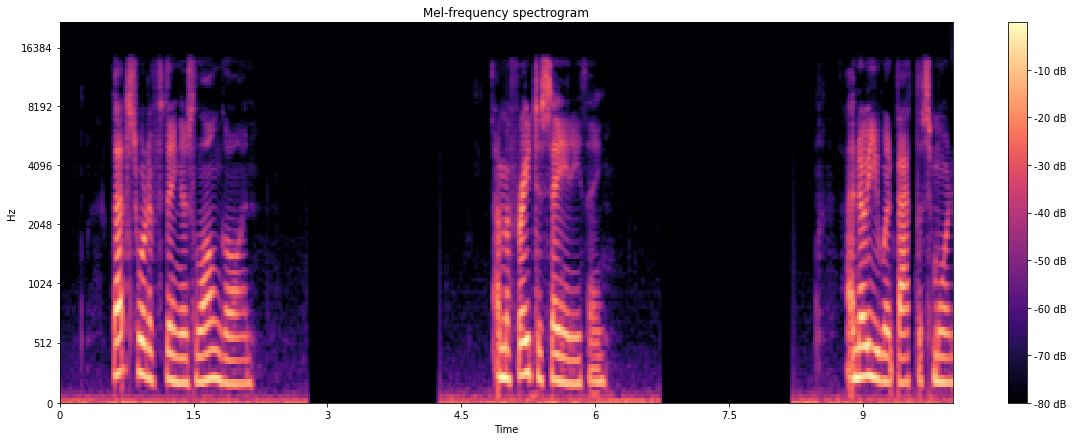

In [ ]:
import librosa.display

ipd.Audio("drive/MyDrive/Noise suppression/_clean_sample_typing.wav")
a, sr = lr.load("drive/MyDrive/Noise suppression/_clean_sample_typing.wav", duration=10)
S = lr.feature.melspectrogram(y=a, sr=sr)
fig, ax = plt.subplots(figsize=(20, 7))
S_dB = lr.power_to_db(S, ref=np.max)
img = lr.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
model = load_model("proposed_model_typing.h5", custom_objects={'mycost': mycost, 'msse':msse, 'my_crossentropy':my_crossentropy, 'my_accuracy':my_accuracy})
# Make sure the MFCC parameters inside the voice_denoise() are the same as our gen_dataset.

# Load noisy file
(sig, rate) = lr.load("drive/MyDrive/Noise suppression/_noisy_sample_typing.wav", sr=16000)
# sig = np.asarray(sig * 32767, dtype=np.int16)
print('min: ', np.min(sig))
print('max: ', np.max(sig))
print('rate: ', rate)
# Denoising
filtered_sig = voice_denoise(sig, rate, model, timestamp_size, numcep=y_train.shape[-1], plot=True) # use plot=True argument to see the gains/vad
filtered_sig = np.asarray(filtered_sig * 32767, dtype=np.int16)
# Write denoised file
sf.write("_pm_typing_filtered_sample_typing.wav", filtered_sig, rate)

print('min: ', np.min(filtered_sig))
print('max: ', np.max(filtered_sig))

NameError: ignored

In [20]:
rate = 8000
(x, _) = lr.load("drive/MyDrive/Noise suppression/Street_example/clnsp136.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

# (y, _) = lr.load("drive/MyDrive/Noise suppression/Street_example/noisy136_SNRdb_20.0_clnsp136.wav", rate, duration=30)
(y, _) = lr.load("drive/MyDrive/Noise suppression/Street_example/_rnndenoise_denoised_noisy136_15.wav", rate, duration=30)
y = np.asarray(y * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, y, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, y, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (2.987199746079104, 2.803298234939575)
stoi:  0.8593946581656147


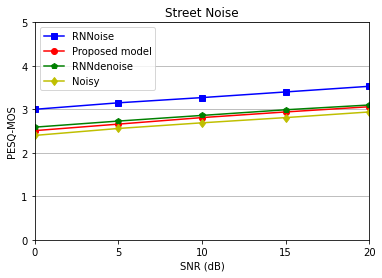

In [23]:
plt.grid(axis='y')
plt.ylabel("PESQ-MOS")
# plt.yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5])
# plt.yticks([2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8])
plt.yticks([0, 1, 2, 3, 4, 5])
plt.ylim(0, 5)
plt.xlabel("SNR (dB)")
plt.xlim(0, 20)
plt.xticks([0, 5, 10, 15, 20])

x = [0, 5, 10, 15, 20]

#RNNoise
y = [3.00, 3.15, 3.27, 3.40, 3.53]

#Proposed model
y1 = [2.51, 2.66, 2.81, 2.94, 3.06]

#RNNdenoise
yden = [2.59, 2.73, 2.86, 2.99, 3.10]

#Noisy
y2 = [2.40, 2.56, 2.69, 2.81, 2.94]

plt.title("Street Noise")
plt.plot(x, y, 'bs-', label="RNNoise", markersize=6)
plt.plot(x, y1, 'ro-', label="Proposed model", markersize=6)
plt.plot(x, yden, 'gp-', label="RNNdenoise", markersize=6)
plt.plot(x, y2, 'yd-', label="Noisy", markersize=6)
plt.legend()
plt.show()

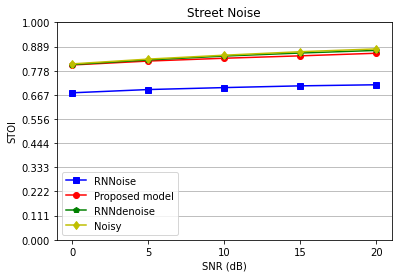

In [22]:
plt.grid(axis='y')
plt.ylabel("STOI")
# plt.yticks([0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1])
plt.yticks(np.linspace(0, 1, 10))
plt.ylim(0, 1)
plt.xlabel("SNR (dB)")
plt.xticks([0, 5, 10, 15, 20])

xs = [0, 5, 10, 15, 20]

#RNNoise
ys = [0.676, 0.691, 0.700, 0.708, 0.713]

#Proposed model
ys1 = [0.804, 0.822, 0.835, 0.846, 0.858]

#RNNdenoise
yden = [0.806, 0.827, 0.845, 0.859, 0.871]

#Noisy
ys2 = [0.809, 0.831, 0.849, 0.865, 0.878]

plt.title("Street Noise")
plt.plot(xs, ys, 'bs-', label="RNNoise", markersize=6)
plt.plot(xs, ys1, 'ro-', label="Proposed model", markersize=6)
plt.plot(xs, yden, 'gp-', label="RNNdenoise", markersize=6)
plt.plot(xs, ys2, 'yd-', label="Noisy", markersize=6)
plt.legend()
plt.show()

In [34]:
rate = 8000
(x, _) = lr.load("drive/MyDrive/Noise suppression/Typing_example/clnsp11.wav", sr=rate, duration=30)
# (x, _) = lr.load("drive/MyDrive/Noise suppression/_clean_sample_typing.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

# (y, _) = lr.load("drive/MyDrive/Noise suppression/noisy11_SNRdb_20.0_clnsp11.wav", rate, duration=30)
(y, _) = lr.load("drive/MyDrive/Noise suppression/_pm_nsc-tot_denoised_noisy11_20.wav", rate, duration=30)
y = np.asarray(y * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, y, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, y, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (2.8052884623959216, 2.539172887802124)
stoi:  0.8601087759801113


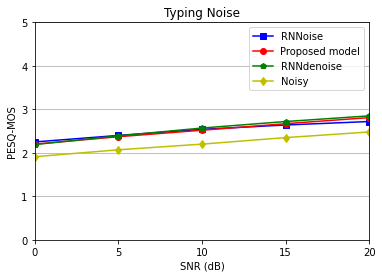

In [27]:
plt.grid(axis='y')
plt.ylabel("PESQ-MOS")
# plt.yticks([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5])
# plt.yticks([2.4, 2.6, 2.8, 3, 3.2, 3.4, 3.6, 3.8])
plt.yticks([0, 1, 2, 3, 4, 5])
plt.ylim(0, 5)
plt.xlabel("SNR (dB)")
plt.xlim(0, 20)
plt.xticks([0, 5, 10, 15, 20])

x = [0, 5, 10, 15, 20]

#RNNoise
y = [2.25, 2.40, 2.54, 2.64, 2.72]

#Proposed model
y1 = [2.20, 2.37, 2.52, 2.67, 2.81]

#RNNdenoise
yden = [2.19, 2.39, 2.57, 2.72, 2.85]

#Noisy
y2 = [1.91, 2.07, 2.20, 2.35, 2.48]

plt.title("Typing Noise")
plt.plot(x, y, 'bs-', label="RNNoise", markersize=6)
plt.plot(x, y1, 'ro-', label="Proposed model", markersize=6)
plt.plot(x, yden, 'gp-', label="RNNdenoise", markersize=6)
plt.plot(x, y2, 'yd-', label="Noisy", markersize=6)
plt.legend()
plt.show()

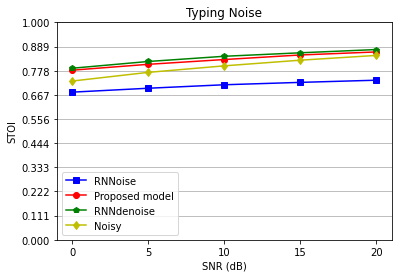

In [28]:
plt.grid(axis='y')
plt.ylabel("STOI")
# plt.yticks([0.65, 0.675, 0.7, 0.725, 0.75, 0.775, 0.8, 0.825, 0.85, 0.875, 0.9, 0.925, 0.95, 0.975, 1])
plt.yticks(np.linspace(0, 1, 10))
plt.ylim(0, 1)
plt.xlabel("SNR (dB)")
plt.xticks([0, 5, 10, 15, 20])

xs = [0, 5, 10, 15, 20]

#RNNoise
ys = [0.679, 0.697, 0.713, 0.724, 0.734]

#Proposed model
ys1 = [0.780, 0.807, 0.829, 0.850, 0.864]

#RNNdenoise
yden = [0.789, 0.820, 0.844, 0.860, 0.875]

#Noisy
ys2 = [0.730, 0.770, 0.800, 0.826, 0.848]

plt.title("Typing Noise")
plt.plot(xs, ys, 'bs-', label="RNNoise", markersize=6)
plt.plot(xs, ys1, 'ro-', label="Proposed model", markersize=6)
plt.plot(x, yden, 'gp-', label="RNNdenoise", markersize=6)
plt.plot(xs, ys2, 'yd-', label="Noisy", markersize=6)
plt.legend()
plt.show()

In [10]:
rate = 8000
(x, _) = lr.load("drive/MyDrive/Noise suppression/_noisy_sample_typing.wav", sr=rate, duration=30)
x = np.asarray(x * 32767, dtype=np.int16)

# (y, _) = lr.load("drive/MyDrive/Noise suppression/Typing_example/noisy11_SNRdb_20.0_clnsp11.wav", rate, duration=35)
(y, _) = lr.load("drive/MyDrive/Noise suppression/_pm-tot_denoised_Typing.wav", rate, duration=30)
y = np.asarray(y * 32767, dtype=np.int16)

mos_lqo = pysepm.pesq(x, y, rate)
print('(pesq_mos, mos_lqo): ', mos_lqo)
stoi = pysepm.stoi(x, y, rate)
print('stoi: ', stoi)

(pesq_mos, mos_lqo):  (3.2625260059260026, 3.2133190631866455)
stoi:  0.8935703608160389


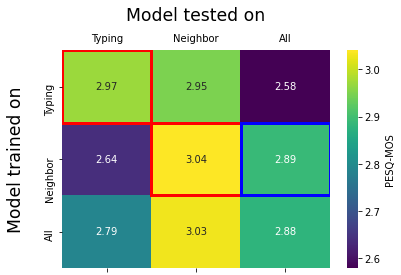

In [80]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

matrix = [[2.97, 2.95, 2.58], [2.64, 3.04, 2.89], [2.79, 3.03, 2.88]]

cmap = sn.color_palette("viridis", as_cmap=True)
ax = sn.heatmap(matrix, annot=True, xticklabels=["Typing", "Neighbor", "All"], yticklabels=["Typing", "Neighbor", "All"], cbar_kws={'label': 'PESQ-MOS'}, cmap=cmap, fmt='g')
ax.add_patch(ax.add_patch(Rectangle((0,0),1,1, fill=False, edgecolor='red', lw=3)))
# ax.add_patch(ax.add_patch(Rectangle((1,2),1,1, fill=False, edgecolor='blue', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((1,1),1,1, fill=False, edgecolor='red', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((2,1),1,1, fill=False, edgecolor='blue', lw=3)))
# ax.add_patch(ax.add_patch(Rectangle((2,2),1,1, fill=False, edgecolor='red', lw=3)))
plt.title("Model tested on", fontsize="xx-large", pad=30.0)
plt.ylabel("Model trained on", labelpad=20.0, fontsize="xx-large")
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labeltop'] = True
plt.show()

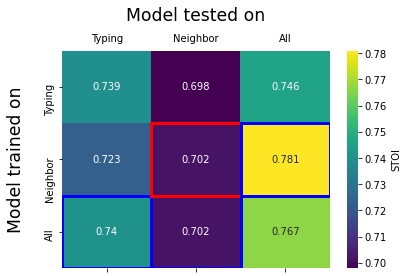

In [82]:
import pandas as pd
import seaborn as sn
from matplotlib.patches import Rectangle

matrix = [[0.739, 0.698, 0.746], [0.723, 0.702, 0.781], [0.740, 0.702, 0.767]]

cmap = sn.color_palette("viridis", as_cmap=True)
ax = sn.heatmap(matrix, annot=True, xticklabels=["Typing", "Neighbor", "All"], yticklabels=["Typing", "Neighbor", "All"], cbar_kws={'label': 'STOI'}, cmap=cmap, fmt='g')
# ax.add_patch(ax.add_patch(Rectangle((0,0),1,1, fill=False, edgecolor='red', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((0,2),1,1, fill=False, edgecolor='blue', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((1,2),1,1, fill=False, edgecolor='blue', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((1,1),1,1, fill=False, edgecolor='red', lw=3)))
ax.add_patch(ax.add_patch(Rectangle((2,1),1,1, fill=False, edgecolor='blue', lw=3)))
# ax.add_patch(ax.add_patch(Rectangle((2,2),1,1, fill=False, edgecolor='red', lw=3)))
plt.title("Model tested on", fontsize="xx-large", pad=30.0)
plt.ylabel("Model trained on", labelpad=20.0, fontsize="xx-large")
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.labeltop'] = True
plt.show()